# San Francisco Rental Prices Dashboard

#### In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [80]:
# initial imports
import os
import pandas as pd
#import matplotlib.pyplot as plt
import hvplot.pandas
import panel as pn
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')

In [81]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY") 
px.set_mapbox_access_token(mapbox_token)

In [82]:
type(mapbox_token)

str

## Import Data

In [83]:
# Import the CSVs to Pandas DataFrames
file_path = Path("sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path) 

## Panel Visualizations

#### In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. These functions will convert the plot object to a Panel pane.

#### Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

#### Return a Panel pane object from each function that can be used to build the dashboard.

#### Note: Remove any .show() lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [84]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    housing_units = sfo_data['housing_units']
    housing_units_per_year = housing_units.groupby('year').mean()
    plot_housing_per_year = housing_units_per_year.hvplot.bar(ylim=(370000,387500),figsize=(10,5),
                                                        title='Average Housing Units Per Year in San Francisco')
    
    return pn.pane.Plotly(plot_housing_per_year)


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""

    gross_rent_sale_price = sfo_data[['gross_rent','sale_price_sqr_foot']]
    average_rent_sale_price = gross_rent_sale_price.groupby('year').mean()
    average_gross_rent = sfo_data['gross_rent'].groupby('year').mean()
    plot_avg_yearly_rent = average_gross_rent.plot.line(figsize=(10,5))
    
    return pn.pane.Plotly(plot_avg_yearly_rent)

def average_sales_price():
    """Average Sales Price Per Year."""
    
    average_sale_price = sfo_data['sale_price_sqr_foot'].groupby('year').mean()
    plot_avg_sale_price = average_sale_price.plot.line(figsize=(10,5))
    
    return pn.pane.Plotly(plot_avg_sale_price)

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    neighborhood_avg = sfo_data.groupby(['neighborhood','year']).mean()
    plot_neighborhood_avg = neighborhood_avg.hvplot.line(
        x = 'year', 
        xlabel = 'Year', 
        y = 'sale_price_sqr_foot',
        ylabel = 'Sale Price per Square Foot',
        groupby="neighborhood")
    
    return pn.pane.Plotly(plot_neighborhood_avg)

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    neighborhood_price = sfo_data.groupby('neighborhood').mean()
    neighborhood_top10 = neighborhood_price.sort_values('sale_price_sqr_foot',ascending=False).head(10)
    neighborhood_top10_price = neighborhood_top10.drop(columns=['housing_units','gross_rent'])
    plot_neighborhood_top10 = neighborhood_top10_price.hvplot.bar(ylabel='Sale Price Per Square Foot',xlabel='Neighborhood',rot=90)
    
    return pn.pane.Plotly(plot_neighborhood_top10)

def parallel_coordinates():
    """Parallel Coordinates Plot."""
    
    neighborhood_price = sfo_data.groupby('neighborhood').mean()
    neighborhood_top10 = neighborhood_price.sort_values('sale_price_sqr_foot',ascending=False).head(10)
    neighborhood_top10.reset_index(inplace=True)
    parallel_coordinates_plot = px.parallel_coordinates(
        neighborhood_top10,
        color='sale_price_sqr_foot')
    
    return parallel_coordinates_plot

def parallel_categories():
    """Parallel Categories Plot."""
    
    neighborhood_price = sfo_data.groupby('neighborhood').mean().reset_index()
    neighborhood_top10 = neighborhood_price.sort_values('sale_price_sqr_foot',ascending=False).head(10)
    
    parallel_categories_plot= px.parallel_categories(
    neighborhood_top10,
    dimensions=['neighborhood','sale_price_sqr_foot','housing_units','gross_rent'],
    color='sale_price_sqr_foot',
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        "neighborhood": "Neighborhood",
        "sale_price_sqr_foot": "Sale Price per Square Foot",
        "housing_units": "Housing Units",
        "gross_rent": "Gross Rent"
            
    })

    return parallel_categories_plot

def neighborhood_map():
    """Neighborhood Map"""
    
    neighborhood_mean_values = sfo_data.groupby('neighborhood').mean().reset_index()
    neighborhood_value_locations = pd.concat([df_neighborhood_locations, neighborhood_mean_values],axis='columns')
    neighborhood_value_locations.drop(columns='neighborhood',inplace=True)
    neighborhood_value_locations = neighborhood_value_locations.drop(columns='Neighborhood')
    
    map = px.scatter_mapbox(
    neighborhood_value_locations,
    lat="Lat",
    lon="Lon",
    size="sale_price_sqr_foot",
    color="gross_rent",
    zoom=10)
    
    return map

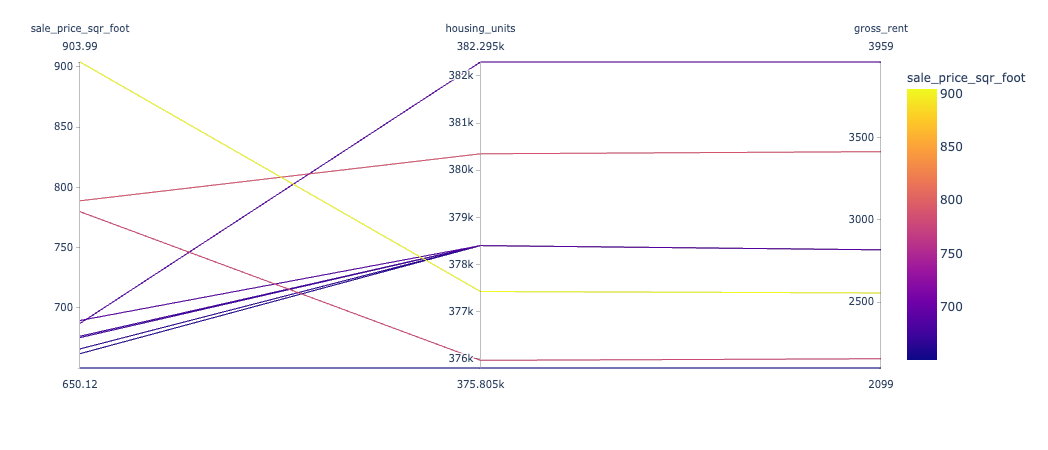

In [85]:
parallel_coordinates()

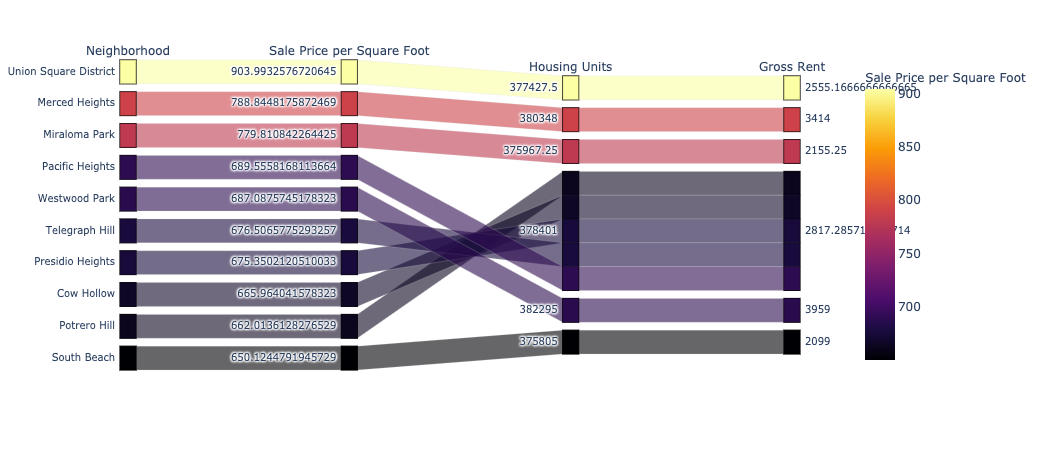

In [86]:
parallel_categories()

## Panel Dashboard

#### In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [87]:
title = '#San Francisco Real Estate Analysis 2010-2016'

opening_tab = pn.Column(title, neighborhood_map())
opening_tab

Column
    [0] Markdown(str)
    [1] Plotly(Figure)

In [88]:
parallel_plots_tab = pn.Column("Parallel Plots",parallel_coordinates(),parallel_categories())
parallel_plots

Column
    [0] Markdown(str)
    [1] Plotly(Figure)
    [2] Plotly(Figure, hover_data={'points': [{'curveNumber'...})

In [74]:
market_analysis_row = pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())


ValueError: Plotly pane does not support objects of type 'Bars'.

In [ ]:
title = '#Real Estate Analysis of San Francisco 2010-2016'

welcome_tab = pn.Row(pn.Column(title), neighborhood_map())

market_analysis_row = pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())


neighborhood_analysis_tab = pn.Column(interact(average_price_by_neighborhood, neighborhood=neighborhood_choice),
    top_most_expensive_neighborhoods()
)

parallel_plots_tab = pn.Column( 
    parallel_categories(),
    parallel_coordinates()
)


# Create tabs

SF_dashboard = pn.Tabs(("Welcome", welcome_tab), 
("Yearly Market Analysis", market_analysis_row),
("Neighborhood Analysis", neighborhood_analysis_tab), 
("Interactive Market Analysis by Neighborhood", parallel_plots_tab))

In [77]:
dashboard = pn.Tabs(
("Opening", opening_tab), 
("Interactive Market Analysis by Neighborhood", parallel_plots_tab))

## Serve the Panel Dashboard

In [89]:
dashboard.servable() 

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure, relayout_data={'mapbox.center': {'lon': ...})
    [1] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)